In [1]:
import pandas as pd
import afqinsight as afq
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, train_test_split
from groupyr.transform import GroupExtractor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import sklearn.metrics

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer

In [20]:
X, y, groups, feature_names, group_names, subjects, _ = afq.datasets.load_afq_data('../data/raw/age_data', "Age")

In [21]:
#group_extractor = GroupExtractor(select=['fa', 'md'], groups=groups, group_names=group_names)
#X = group_extractor.fit_transform(X)

In [22]:
#group_names = [g for g in group_names if g[0] in ['md', 'fa']]
#print(len(group_names))
#print(X.shape)
#groups = groups[0:40]
group_extractor = GroupExtractor(select=['Right Cingulum Cingulate'], groups=groups, group_names=group_names)
X = group_extractor.fit_transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
imp = SimpleImputer(strategy='median')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

In [25]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((57, 500), (57,), (20, 500), (20,))

In [26]:
model = Sequential()

# input: 3+D tensor with shape: batch_shape + (steps, input_dim)
# output: 3+D tensor with shape: batch_shape + (new_steps, filters) steps value might have changed due to padding or strides.
#model.add(Conv1D(32, kernel_size=3, input_shape=X_train.shape[1:], activation='relu'))
# flatten takes feature maps and flattens it into 784 pixels, since dense doesnt care about space
#model.add(MaxPool1D(pool_size=3,padding='same'))
#model.add(Flatten())
model.add(Dense(128, activation='relu', input_shape=X_train.shape[1:]))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               64128     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 72,449
Trainable params: 72,449
Non-trainable params: 0
_________________________________________________________________


In [28]:
#callback = EarlyStopping(monitor='loss', patience=3)
model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test))
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=100)
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

Epoch 1/100
1/1 [==============================] - 1s 565ms/step - loss: 491.6553 - mean_squared_error: 491.6553 - val_loss: 437.1331 - val_mean_squared_error: 437.1331
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 440.5576 - mean_squared_error: 440.5576 - val_loss: 396.2962 - val_mean_squared_error: 396.2962
Epoch 3/100
1/1 [==============================] - 0s 37ms/step - loss: 394.5652 - mean_squared_error: 394.5652 - val_loss: 361.8248 - val_mean_squared_error: 361.8248
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 361.7576 - mean_squared_error: 361.7576 - val_loss: 328.2176 - val_mean_squared_error: 328.2176
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 332.6439 - mean_squared_error: 332.6439 - val_loss: 295.5285 - val_mean_squared_error: 295.5285
Epoch 6/100
1/1 [==============================] - 0s 41ms/step - loss: 315.9508 - mean_squared_error: 315.9508 - val_loss: 264.3543 - val_mean_squared_error: 

In [30]:
import matplotlib.pyplot as plt

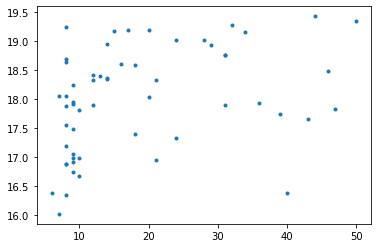

In [31]:
y_hat = model.predict(X_train)
plt.plot(y_train, y_hat, linestyle="", marker=".")

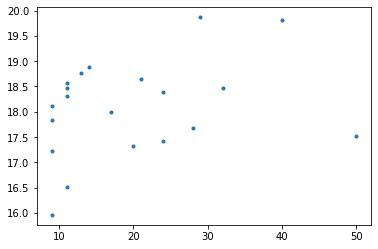

In [32]:
y_hat = model.predict(X_test)
plt.plot(y_test, y_hat, linestyle="", marker=".")